# 2-Classifying Problem with Single qubit[Stochastic]

In [1]:
import pennylane as qml
from pennylane.optimize import GradientDescentOptimizer
from pennylane import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Data Generation

In [2]:
# Setting a random seed for reproducing
np.random.seed(32)

# Making a traing dataset of points inside and outside of a circle
def Circle(samples, condition = [[0.0, 0.0], np.sqrt(2 / np.pi)]):
    """
    INPUT
    samples : the number of data points we will make
    center : center of the circle    
    radius : radius of the circle
    condition : conditions of the circle (condition[0] = center, condition[1] = radius)
    
    OUTPUT
    data points & labels(In - 0/Out - 1) for each point & Condition
    """
    points= []
    labels = []

    for i in range(samples):
        
        # Mading sample points
        point = 2*np.random.rand(2)-1
        label = 0

        # Changing label to 1 if it is out of the circle
        if np.linalg.norm(point - condition[0]) > condition[1]:
            label = 1
        
        # Collecting the sample points
        points.append(point)
        labels.append(label)

    return np.array(points, requires_grad = False), np.array(labels, requires_grad = False), condition

# ----------------------------------------------------------------------------------------------- #

def Sin(samples, condition = [1]):
    """
    INPUT
    samples : the number of data points we will generate
    condition : condtion of the sin function (condition[0] = amplitude, condition[1] = frequency)

    OUTPUT
    data points & labels(Under - 0/Over - 1) for each point & Condition
    """

    points = []
    labels = []

    for i in range(samples):
        point = 2*np.random.rand(2)-1
        label = 0

        if point[1] > condition[0]*np.sin(np.pi*point[0]):
            label = 1

        points.append(point)
        labels.append(label)

    return np.array(points, requires_grad = False), np.array(labels, requires_grad = False), condition


# ----------------------------------------------------------------------------------------------- #

def Sphere(samples, condition = [[0,0,0], np.sqrt(2 / np.pi)]):
    """
    INPUT
    samples : the number of data points we will generate
    condtion : codition of the sphere (condition[0] = center of the sphere, condtion[1] = radius of the sphere)

    OUTPUT
    data points & labels(In - 1/Out - -1) for each point & Condition
    """
    points= []
    labels = []

    for i in range(samples):
        
        # Mading sample points
        point = 2*np.random.rand(3)-1
        label = 0

        # Changing label to 1 if it is out of the circle
        if np.linalg.norm(point - condition[0]) > condition[1]:
            label = 1
        
        # Collecting the sample points
        points.append(point)
        labels.append(label)

    return np.array(points, requires_grad = False), np.array(labels, requires_grad = False), condition

In [3]:
# Plotting the data with figuration
def plot_data(x, y, fig = None, ax = None, problem = "", condition = []):
    """
    Plotting the data with the binary classification

    data_points : data_points that will be plotted on the graph
    data_labels : which classify the points with different colors

    Return
    plot graph
    """
    # Graph figure
    if fig == None :
        fig, ax = plt.subplots(1,1,figsize = (5, 5))
    
    # Giving color for each point
    red = y == 0
    blue = y == 1
    if problem == None:
        print("Define the problem")
    
    if problem == "circle":
        draw_circle = plt.Circle(condition[0], condition[1], fill=False)
        ax.scatter(x[red,0],x[red,1], c = "red", s = 10)
        ax.scatter(x[blue,0],x[blue,1], c = "blue", s = 10)
        ax.add_artist(draw_circle)
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")

    if problem == "sin":
        x1 = np.linspace(-1, 1)
        x2 = condition[0]*np.sin(np.pi*x1)
        ax.scatter(x[red,0],x[red,1], c = "red", s = 10)
        ax.scatter(x[blue,0],x[blue,1], c = "blue", s = 10)
        ax.plot(x1, x2)
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")

    if problem == "sphere":
        theta = np.linspace(0,2*np.pi)
        phi = np.linspace(0, 2*np.pi)
        theta, phi = np.meshgrid(theta, phi)
        r = condition[1]
        x1 = condition[0][0] + r*np.cos(theta)*np.sin(phi)
        x2 = condition[0][1] + r*np.sin(theta)*np.sin(phi)
        x3 = condition[0][2] + r*np.cos(phi)
        ax.scatter(x[red,0],x[red,1],x[red,2], c = "red")
        ax.scatter(x[blue,0],x[blue,1],x[blue,2], c = "blue")
        ax.plot_surface(x1, x2, x3, cmap="viridis", ec="k", lw=0.05, alpha=0.0)
        ax.set_box_aspect((1, 1, 1))
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")
        ax.set_zlabel("$x_3$")



#fig, ax = plt.subplots(figsize=(4, 4),subplot_kw={"projection":"3d"})
#Xpoints, Ylabels, condition = Sphere(500)
#print(Xpoints[0])
#plot_data(Xpoints, Ylabels, fig = fig, ax = ax, problem = "sphere" , condition=condition)

### Designing the Quantum Circuit Model

In [4]:
dev_stochastic = qml.device("lightning.qubit", wires=1, shots=1000)

@qml.qnode(dev_stochastic)
def SQC_orign(params, x):
    """
    Design the circuit model with the origin scheme

    INPUT
    params : parameters for the Uitary Gate U(p) (num_layers, 3)
    x : one data point (1, 3)
    y : label of the data point

    OUPUT
    expectation vlaue of the circuit
    """
    ### Origin scheme
    for p in params:
        qml.Rot(*p, wires = 0)
        qml.Rot(*x, wires = 0)
    
    return qml.expval(qml.PauliZ(0))

In [5]:
dev_stochastic = qml.device("lightning.qubit", wires=1, shots=1000)

@qml.qnode(dev_stochastic)
def SQC_comp(thetas, weights, x):
    """
    Variational Quantum Circuit for Universal Quantum Classifier
    Fig1.(b) Compressed Scheme

    theta : array of theta...bias (theta_1, theta_2, theta_3)
    weight : array of wegiht...weight (w_1, w_2, w_3)
    x : Datas where we have to input (x_1, x_2, 0)
    y : Expected ouput density matrix

    Returns
    Expectation value
    """
    params = []
    for i in range(len(thetas)):
        params.append(thetas[i]+weights[i]*x)

    # Compressed scheme
    for p in params:
        qml.Rot(*p, wires = 0)
    
    # Calculating the expectation value of the supplied observable
    return qml.expval(qml.PauliZ(0))

### Loss function

In [6]:
def loss_functionO(params, x, y):
    """
    loss function to be minimized

    INPUT
    params : parmeters that will be used
    x : data points for re-uploading
    
    OUTPUT
    loss value to be minimized
    """

    loss = 0.0

    for i in range(len(x)):
        f = SQC_orign(params, x[i])
        if y[i] == 0:
            loss += (1 - f)**2
        else:
            loss += (1 + f)**2
    return loss / len(x)

In [7]:
def loss_functionC(thetas, weights, x, y):
    """
    loss function to be minimized

    INPUT
    circuit : the circuit model of the classifier
    params : parmeters that will be used
    x : data points for re-uploading
    
    OUTPUT
    loss value to be minimized
    """

    loss = 0.0

    for i in range(len(x)):
        f = SQC_comp(thetas, weights, x[i])
        if y[i] == 0:
            loss += (1 - f)**2
        else:
            loss += (1 + f)**2
    return loss / len(x)

### Model Runnig

In [8]:
def model_runningO(params, x):
    """
    Model running with given set of data.

    INPUT
    params : array of parameters (num_layers, 3)
    x : array of data points (num_data, 3)
    y : array of true data labels (num_data, 1)
    state_labels : state representations for labels

    Returns
    Predicted labels for given data, Expectation value of the circuit
    """
    predicted = []
    exepctation_values = []
    for i in range(len(x)):
        expval = SQC_orign(params, x[i])
        exepctation_values.append(expval)
        
        if expval >= 0 :
            predicted.append(0)
        else:
            predicted.append(1)
        
    return np.array(predicted), np.array(exepctation_values)

In [9]:
def model_runningC(thetas, weights, x):
    """
    Model running with given set of data.

    INPUT
    params : array of parameters (num_layers, 3)
    x : array of data points (num_data, 3)
    y : array of true data labels (num_data, 1)
    state_labels : state representations for labels

    Returns
    Predicted labels for given data, Expectation value of the circuit
    """
    predicted = []
    exepctation_values = []
    for i in range(len(x)):
        expval = SQC_comp(thetas, weights, x[i])
        exepctation_values.append(expval)
        
        if expval >= 0 :
            predicted.append(0)
        else:
            predicted.append(1)
        
    return np.array(predicted), np.array(exepctation_values)

### Accuracy Score

In [10]:
def accuracy_score(y_true, y_pred):
    """
    Accuracy score. Evaluating the model with the label comparing.
    
    INPUT
    y_true : Targets(Answers)
    y_predicted : Predictions(labels wihch model has given)

    OUTPUT
    the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)

### Making batches for optimizing

In [11]:
def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data
    
    INPUT
    inputs : input data
    targets : targets
    batch_size : size of the batch, the number of datas in one batch

    Returns
    one batch of input data of length `batch_size`, one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

## Process of Origin scheme SQC

In [ ]:
### Origin scheme sinle-qubit classifier model

# the numbers of training and test data
num_training = 500
num_test = 4000

# Training datas(where we will train the data)
Xdata, y_train, condition = Circle(num_training)
# for 2-dim points
train_data = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False))) # point (x_1, x_2, x_3 = 0)

# Testing datas(where we get the model accuracy)
Xtest, y_test, condition = Circle(num_test)
# for 2-dim points
test_data = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False))) # point (x_1, x_2, x_3 = 0)

# Setting the training options
num_layers = 6
epochs = 50
batch_size = 50
eta = 0.1

# Using the Optimizer
opt = GradientDescentOptimizer(eta)

# Initializing random weights the parameters for U(p)
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

### Evaluating the classifier
# Running the model with test data
predicted_train, expvals_train = model_runningO(params, train_data)
accuracy_train = accuracy_score(y_train, predicted_train)

# Running the model with the test data
predicted_test, expvals_test = model_runningO(params, test_data)
accuracy_test = accuracy_score(y_test, predicted_test)

# Saving predictions with random weights for comparison 
initial_predictions = predicted_test

loss = loss_functionO(params, test_data, y_test)

loss_list, accuracy_train_list, accuracy_test_list = [], [], []
loss_list.append(loss)
accuracy_train_list.append(accuracy_train)
accuracy_test_list.append(accuracy_test)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, y_train, batch_size=batch_size):
        params, _, _ = opt.step(loss_functionO, params, Xbatch, ybatch)

    predicted_train, expvals_train = model_runningO(params, train_data)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = loss_functionO(params, train_data, y_train)

    predicted_test, expvals_test = model_runningO(params, test_data)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

    loss_list.append(loss)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)

### Classifying Results

In [ ]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: prameters = {}".format(i,params[i]))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(test_data, initial_predictions, fig, axes[0], problem = "circle", condition = condition)
plot_data(test_data, predicted_test, fig, axes[1], problem = "circle", condition = condition)
plot_data(test_data, y_test, fig, axes[2], problem = "circle", condition = condition)

axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(loss_list,'.-')
axes[1].plot(accuracy_test_list,'.-', label = 'Test_accuracy')
axes[1].plot(accuracy_train_list,'.-', label = 'Train_accuracy')
axes[1].legend()
axes[1].set_ylim(top = 1.0)
axes[0].set_title(f"Loss from fidelity cost function (Layers = {num_layers})")
axes[1].set_title(f"Accuracy(Layers = {num_layers})")
plt.show()

_____

## Process of Compressed scheme SQC

In [19]:
# the numbers of training and test data
num_training = 500
num_test = 4000

# Training datas(where we will train the data)
Xdata, y_train, condition = Circle(num_training)
train_data = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False))) # point (x_1, x_2, x_3 = 0)

# Testing datas(where we get the model accuracy)
Xtest, y_test, condition = Circle(num_test)
test_data = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False))) # point (x_1, x_2, x_3 = 0)

# Setting the training options
num_layers = 6
epochs = 50
batch_size = 50
eta = 0.1

# Using the Optimizer
opt = GradientDescentOptimizer(eta)

# Initializing random weights the parameters for U(p)
thetas = np.random.uniform(size=(num_layers, 3), requires_grad=True)
weights = np.random.uniform(size=(num_layers, 3), requires_grad=True)

### Evaluating the classifier
# Running the model with test data
predicted_train, expvals_train = model_runningC(thetas, weights, train_data)
accuracy_train = accuracy_score(y_train, predicted_train)

# Running the model with the test data
predicted_test, expvals_test = model_runningC(thetas, weights, test_data)
accuracy_test = accuracy_score(y_test, predicted_test)

# Saving predictions with random weights for comparison 
initial_predictions = predicted_test

loss = loss_functionC(thetas, weights, test_data, y_test)

loss_list, accuracy_train_list, accuracy_test_list = [], [], []
loss_list.append(loss)
accuracy_train_list.append(accuracy_train)
accuracy_test_list.append(accuracy_test)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, y_train, batch_size=batch_size):
        thetas, weights, _, _ = opt.step(loss_functionC, thetas, weights, Xbatch, ybatch)

    predicted_train, expvals_train = model_runningC(thetas, weights, train_data)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = loss_functionC(thetas, weights, train_data, y_train)

    predicted_test, expvals_test = model_runningC(thetas, weights, test_data)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )
    
    loss_list.append(loss)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)

Epoch:  0 | Cost: 1.060519 | Train accuracy: 0.634000 | Test Accuracy: 0.644000
Epoch:  1 | Loss: 0.781155 | Train accuracy: 0.702000 | Test accuracy: 0.700000
Epoch:  2 | Loss: 0.665274 | Train accuracy: 0.760000 | Test accuracy: 0.762500
Epoch:  3 | Loss: 0.626600 | Train accuracy: 0.778000 | Test accuracy: 0.776500
Epoch:  4 | Loss: 0.567079 | Train accuracy: 0.814000 | Test accuracy: 0.798500
Epoch:  5 | Loss: 0.450274 | Train accuracy: 0.864000 | Test accuracy: 0.852250
Epoch:  6 | Loss: 0.419367 | Train accuracy: 0.902000 | Test accuracy: 0.892000
Epoch:  7 | Loss: 0.412170 | Train accuracy: 0.902000 | Test accuracy: 0.901500
Epoch:  8 | Loss: 0.406333 | Train accuracy: 0.912000 | Test accuracy: 0.904750
Epoch:  9 | Loss: 0.407355 | Train accuracy: 0.916000 | Test accuracy: 0.909000
Epoch: 10 | Loss: 0.408072 | Train accuracy: 0.908000 | Test accuracy: 0.910750
Epoch: 11 | Loss: 0.409097 | Train accuracy: 0.912000 | Test accuracy: 0.911750
Epoch: 12 | Loss: 0.407104 | Train accur

### Classifying Results

Cost: 0.406768 | Train accuracy 0.910000 | Test Accuracy : 0.910250
Learned weights
Layer 0: thetas = [0.88416049 1.48763534 0.59448231], weights = [ 0.76798982 -0.02057949  0.90457854]
Layer 1: thetas = [0.40080043 0.95624445 0.42140462], weights = [0.00479773 0.02272385 0.11964421]
Layer 2: thetas = [0.53574439 0.61632759 0.76619967], weights = [0.06140539 0.55460506 0.57316423]
Layer 3: thetas = [0.14230229 0.08925122 0.35169231], weights = [0.87124833 1.03817975 0.01776679]
Layer 4: thetas = [-0.39126286  0.80560949 -0.01971054], weights = [1.0757072  0.71153116 0.51413847]
Layer 5: thetas = [-0.10934629  0.77509422  0.88914263], weights = [ 0.38163296 -0.0013688   0.74118303]


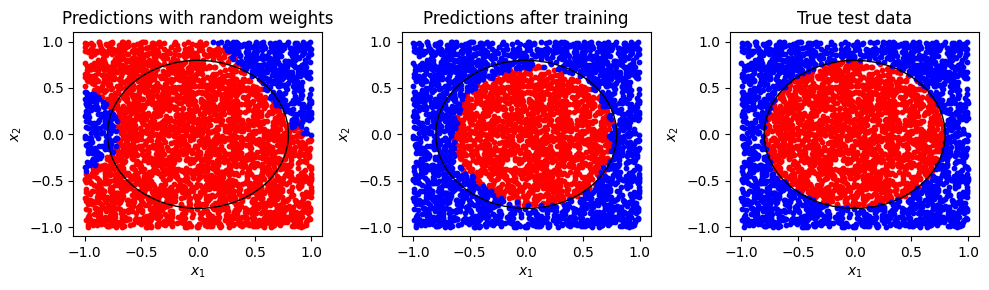

In [20]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: thetas = {}, weights = {}".format(i, thetas[i], weights[i]))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(test_data, initial_predictions, fig, axes[0], problem = "circle", condition = condition)
plot_data(test_data, predicted_test, fig, axes[1], problem = "circle", condition = condition)
plot_data(test_data, y_test, fig, axes[2], problem = "circle", condition = condition)

axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

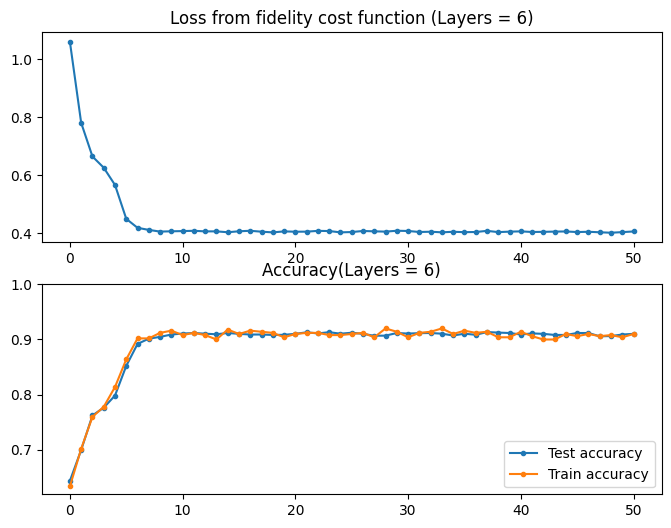

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(loss_list,'.-')
axes[1].plot(accuracy_test_list,'.-', label = 'Test accuracy')
axes[1].plot(accuracy_train_list,'.-', label = 'Train accuracy')
axes[1].set_ylim(top = 1.0)
axes[1].legend()
axes[0].set_title(f"Loss from fidelity cost function (Layers = {num_layers})")
axes[1].set_title(f"Accuracy(Layers = {num_layers})")
plt.show()

--------

In [29]:
### Origin scheme sinle-qubit classifier model

# the numbers of training and test data
num_training = 500
num_test = 4000

# Training datas(where we will train the data)
Xdata, y_train, condition = Sin(num_training)
# for 2-dim points
train_data = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False))) # point (x_1, x_2, x_3 = 0)

# Testing datas(where we get the model accuracy)
Xtest, y_test, condition = Sin(num_test)
# for 2-dim points
test_data = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False))) # point (x_1, x_2, x_3 = 0)

# Setting the training options
num_layers = 6
epochs = 50
batch_size = 50
eta = 0.1

# Initializing random weights the parameters for U(p)
thetas = np.random.uniform(size=(num_layers, 3), requires_grad=True)
weights = np.random.uniform(size=(num_layers, 3), requires_grad=True)

### Evaluating the classifier
# Running the model with test data
predicted_train, expvals_train = model_runningC(thetas, weights, train_data)
accuracy_train = accuracy_score(y_train, predicted_train)

# Running the model with the test data
predicted_test, expvals_test = model_runningC(thetas, weights, test_data)
accuracy_test = accuracy_score(y_test, predicted_test)

# Saving predictions with random weights for comparison 
initial_predictions = predicted_test

loss = loss_functionC(thetas, weights, test_data, y_test)

loss_list, accuracy_train_list, accuracy_test_list = [], [], []
loss_list.append(loss)
accuracy_train_list.append(accuracy_train)
accuracy_test_list.append(accuracy_test)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, y_train, batch_size=batch_size):
        thetas, weights, _, _ = opt.step(loss_functionC, thetas, weights, Xbatch, ybatch)

    predicted_train, expvals_train = model_runningC(thetas, weights, train_data)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = loss_functionC(thetas, weights, train_data, y_train)

    predicted_test, expvals_test = model_runningC(thetas, weights, test_data)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )
    
    loss_list.append(loss)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)

Epoch:  0 | Cost: 1.394053 | Train accuracy: 0.506000 | Test Accuracy: 0.516000
Epoch:  1 | Loss: 0.410327 | Train accuracy: 0.904000 | Test accuracy: 0.877500
Epoch:  2 | Loss: 0.370542 | Train accuracy: 0.924000 | Test accuracy: 0.899500
Epoch:  3 | Loss: 0.347061 | Train accuracy: 0.920000 | Test accuracy: 0.909750
Epoch:  4 | Loss: 0.335102 | Train accuracy: 0.932000 | Test accuracy: 0.917000
Epoch:  5 | Loss: 0.325826 | Train accuracy: 0.934000 | Test accuracy: 0.921250
Epoch:  6 | Loss: 0.313183 | Train accuracy: 0.940000 | Test accuracy: 0.933250
Epoch:  7 | Loss: 0.304103 | Train accuracy: 0.950000 | Test accuracy: 0.942750
Epoch:  8 | Loss: 0.294456 | Train accuracy: 0.958000 | Test accuracy: 0.950500
Epoch:  9 | Loss: 0.281735 | Train accuracy: 0.962000 | Test accuracy: 0.956500
Epoch: 10 | Loss: 0.274295 | Train accuracy: 0.964000 | Test accuracy: 0.959250
Epoch: 11 | Loss: 0.265591 | Train accuracy: 0.966000 | Test accuracy: 0.960750
Epoch: 12 | Loss: 0.261999 | Train accur

Cost: 0.192309 | Train accuracy 0.970000 | Test Accuracy : 0.954000
Learned weights
Layer 0: thetas = [0.66624025 0.11119224 0.94042475], weights = [0.0159437  1.42581014 0.21315349]
Layer 1: thetas = [1.04449863 0.38239936 1.55413166], weights = [1.46486655 0.55297694 0.51189825]
Layer 2: thetas = [1.3459233  0.61898324 0.11374158], weights = [0.66429968 0.32586585 0.55599603]
Layer 3: thetas = [-0.10136681  0.68146518  0.07509425], weights = [1.03532537 0.6029068  0.7934882 ]
Layer 4: thetas = [-0.26966514  0.50758338  0.89104049], weights = [ 1.21153909 -0.0981207   0.30364336]
Layer 5: thetas = [0.78853701 1.47459514 0.19491511], weights = [1.91944915 0.64118921 0.43953729]


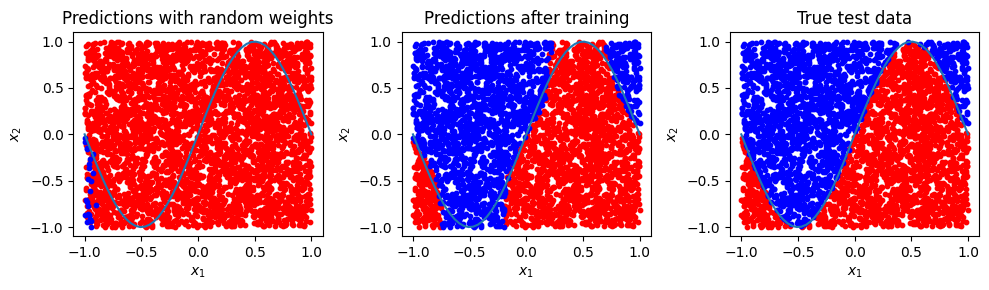

In [30]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: thetas = {}, weights = {}".format(i, thetas[i], weights[i]))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(test_data, initial_predictions, fig, axes[0], problem = "sin", condition = condition)
plot_data(test_data, predicted_test, fig, axes[1], problem = "sin", condition = condition)
plot_data(test_data, y_test, fig, axes[2], problem = "sin", condition = condition)

axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

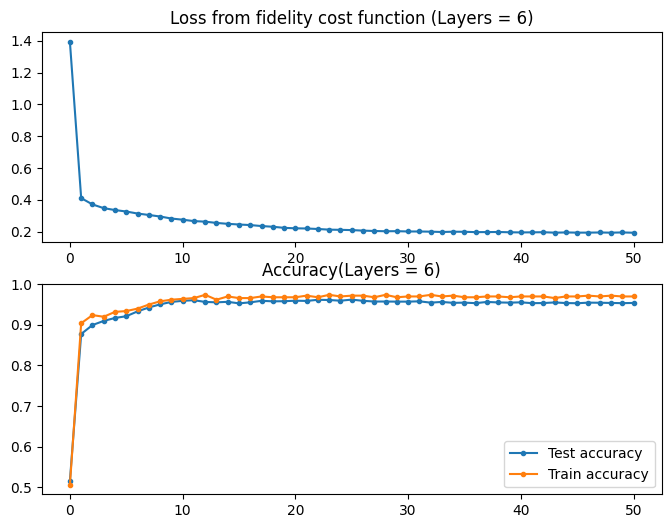

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(loss_list,'.-')
axes[1].plot(accuracy_test_list,'.-', label = 'Test accuracy')
axes[1].plot(accuracy_train_list,'.-', label = 'Train accuracy')
axes[1].set_ylim(top = 1.0)
axes[1].legend()
axes[0].set_title(f"Loss from fidelity cost function (Layers = {num_layers})")
axes[1].set_title(f"Accuracy(Layers = {num_layers})")
plt.show()

--------

In [32]:
### Origin scheme sinle-qubit classifier model

# the numbers of training and test data
num_training = 750
num_test = 2000

# Training datas(where we will train the data)
train_data, y_train, condition = Sphere(num_training)

# Testing datas(where we get the model accuracy)
test_data, y_test, condition = Sphere(num_test)

# Setting the training options
num_layers = 6
epochs = 50
batch_size = 50
eta = 0.1

# Using the Optimizer
opt = GradientDescentOptimizer(eta)

# Initializing random weights the parameters for U(p)
thetas = np.random.uniform(size=(num_layers, 3), requires_grad=True)
weights = np.random.uniform(size=(num_layers, 3), requires_grad=True)

### Evaluating the classifier
# Running the model with test data
predicted_train, expvals_train = model_runningC(thetas, weights, train_data)
accuracy_train = accuracy_score(y_train, predicted_train)

# Running the model with the test data
predicted_test, expvals_test = model_runningC(thetas, weights, test_data)
accuracy_test = accuracy_score(y_test, predicted_test)

# Saving predictions with random weights for comparison 
initial_predictions = predicted_test

loss = loss_functionC(thetas, weights, test_data, y_test)

loss_list, accuracy_train_list, accuracy_test_list = [], [], []
loss_list.append(loss)
accuracy_train_list.append(accuracy_train)
accuracy_test_list.append(accuracy_test)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, y_train, batch_size=batch_size):
        thetas, weights, _, _ = opt.step(loss_functionC, thetas, weights, Xbatch, ybatch)

    predicted_train, expvals_train = model_runningC(thetas, weights, train_data)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = loss_functionC(thetas, weights, train_data, y_train)

    predicted_test, expvals_test = model_runningC(thetas, weights, test_data)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )
    
    loss_list.append(loss)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)

Epoch:  0 | Cost: 1.817873 | Train accuracy: 0.364000 | Test Accuracy: 0.352000
Epoch:  1 | Loss: 0.839823 | Train accuracy: 0.658667 | Test accuracy: 0.667500
Epoch:  2 | Loss: 0.746087 | Train accuracy: 0.725333 | Test accuracy: 0.737500
Epoch:  3 | Loss: 0.735910 | Train accuracy: 0.725333 | Test accuracy: 0.738500
Epoch:  4 | Loss: 0.728164 | Train accuracy: 0.725333 | Test accuracy: 0.738500
Epoch:  5 | Loss: 0.716231 | Train accuracy: 0.725333 | Test accuracy: 0.738500
Epoch:  6 | Loss: 0.700982 | Train accuracy: 0.725333 | Test accuracy: 0.738500
Epoch:  7 | Loss: 0.683233 | Train accuracy: 0.725333 | Test accuracy: 0.738500
Epoch:  8 | Loss: 0.670238 | Train accuracy: 0.725333 | Test accuracy: 0.738500
Epoch:  9 | Loss: 0.653233 | Train accuracy: 0.725333 | Test accuracy: 0.738500
Epoch: 10 | Loss: 0.631908 | Train accuracy: 0.728000 | Test accuracy: 0.738500
Epoch: 11 | Loss: 0.617500 | Train accuracy: 0.741333 | Test accuracy: 0.749500
Epoch: 12 | Loss: 0.602112 | Train accur

Cost: 0.469042 | Train accuracy 0.818667 | Test Accuracy : 0.822500
Learned weights
Layer 0: thetas = [0.67934505 1.04614869 0.56495611], weights = [ 0.98015921  0.14931074 -0.26076489]
Layer 1: thetas = [ 0.45252268 -0.34330381  0.65141541], weights = [ 1.96259829  0.88731421 -0.01316498]
Layer 2: thetas = [0.31009232 0.68679051 0.13698105], weights = [ 0.17419515  0.24118227 -0.00516428]
Layer 3: thetas = [0.2287902  1.01549463 0.54853198], weights = [ 0.52305911  0.99276652 -0.13183902]
Layer 4: thetas = [0.78528519 1.24504919 0.15931011], weights = [ 0.63480502 -1.07738367 -0.18484895]
Layer 5: thetas = [ 0.00286095 -0.50625247  0.91833329], weights = [ 1.22879741 -0.88642602  0.08002277]


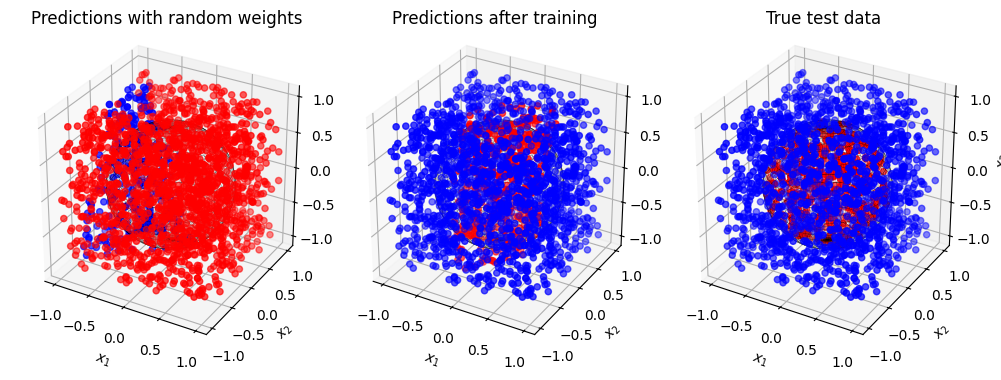

In [34]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: thetas = {}, weights = {}".format(i, thetas[i], weights[i]))

fig, axes = plt.subplots(1, 3, figsize=(10, 6),subplot_kw={"projection":"3d"})
plot_data(test_data, initial_predictions, fig, axes[0], problem = "sphere", condition = condition)
plot_data(test_data, predicted_test, fig, axes[1], problem = "sphere", condition = condition)
plot_data(test_data, y_test, fig, axes[2], problem = "sphere", condition = condition)

axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

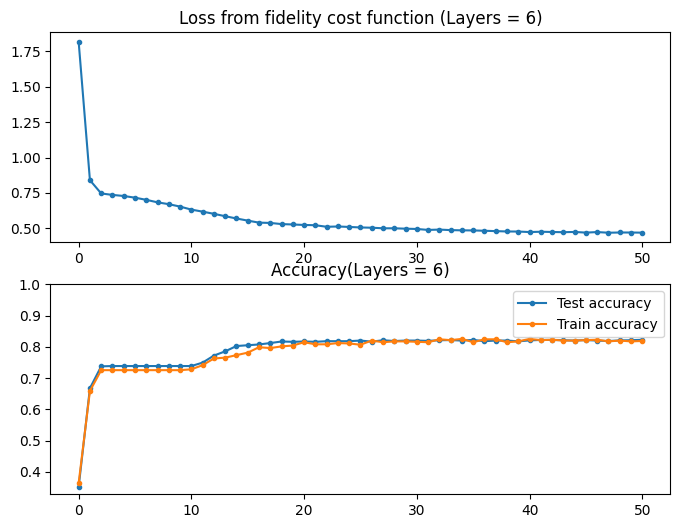

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(loss_list,'.-')
axes[1].plot(accuracy_test_list,'.-', label = 'Test accuracy')
axes[1].plot(accuracy_train_list,'.-', label = 'Train accuracy')
axes[1].set_ylim(top = 1.0)
axes[1].legend()
axes[0].set_title(f"Loss from fidelity cost function (Layers = {num_layers})")
axes[1].set_title(f"Accuracy(Layers = {num_layers})")
plt.show()